In [6]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from matplotlib.lines import Line2D
from lenstronomy.Plots import plot_util as len_plot_util

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import plot_util
from mejiro.utils import util

In [7]:
ps_dir = os.path.join(data_dir, 'output', 'power_spectra_parallelized')
r = np.load(os.path.join(ps_dir, 'r.npy'))

Grab all data where we vary subhalo populations

In [18]:
power_list_wdm = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_subs_wdm.npy')))]
power_list_mdm = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_subs_mdm.npy')))]
power_list_cdm = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_subs_cdm.npy')))]

stack_list_wdm = np.vstack(power_list_wdm)
stack_list_mdm = np.vstack(power_list_mdm)
stack_list_cdm = np.vstack(power_list_cdm)

res_wdm = np.mean(stack_list_wdm, axis=0) - np.mean(stack_list_cdm, axis=0)
res_mdm = np.mean(stack_list_mdm, axis=0) - np.mean(stack_list_cdm, axis=0)

# TODO make percentile instead of std because doesn't reflect asymmetry of distribution
std_wdm = np.std(stack_list_wdm - stack_list_cdm, axis=0, ddof=1)
std_mdm = np.std(stack_list_mdm - stack_list_cdm, axis=0, ddof=1)

assert res_wdm.shape == res_mdm.shape == std_wdm.shape == std_mdm.shape == r.shape

Grab all data where we vary detector positions

In [9]:
power_list_control = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_control.npy')))]
power_list_pos_1 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_1.npy')))]
power_list_pos_2 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_2.npy')))]
power_list_pos_3 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'*_ps_pos_3.npy')))]

stack_control = np.vstack(power_list_control)
stack_list_pos_1 = np.vstack(power_list_pos_1)
stack_list_pos_2 = np.vstack(power_list_pos_2)
stack_list_pos_3 = np.vstack(power_list_pos_3)

dif_pos_1 = np.mean(stack_list_pos_1, axis=0) - np.mean(stack_control, axis=0)
dif_pos_2 = np.mean(stack_list_pos_2, axis=0) - np.mean(stack_control, axis=0)
dif_pos_3 = np.mean(stack_list_pos_3, axis=0) - np.mean(stack_control, axis=0)

std_pos_1 = np.std(stack_list_pos_1 - stack_control, axis=0, ddof=1)
std_pos_2 = np.std(stack_list_pos_2 - stack_control, axis=0, ddof=1)
std_pos_3 = np.std(stack_list_pos_3 - stack_control, axis=0, ddof=1)

Get subhalo mass functions

Average number of subhalos: 2737
Square root: 52
[1.00000000e+06 2.06913808e+06 4.28133240e+06 8.85866790e+06
 1.83298071e+07 3.79269019e+07 7.84759970e+07 1.62377674e+08
 3.35981829e+08 6.95192796e+08 1.43844989e+09 2.97635144e+09
 6.15848211e+09 1.27427499e+10 2.63665090e+10 5.45559478e+10
 1.12883789e+11 2.33572147e+11 4.83293024e+11]
[1.00000000e+06 2.15443469e+06 4.64158883e+06 1.00000000e+07
 2.15443469e+07 4.64158883e+07 1.00000000e+08 2.15443469e+08
 4.64158883e+08 1.00000000e+09 2.15443469e+09 4.64158883e+09
 1.00000000e+10 2.15443469e+10 4.64158883e+10 1.00000000e+11
 2.15443469e+11 4.64158883e+11 1.00000000e+12]
(19,)
(19,)


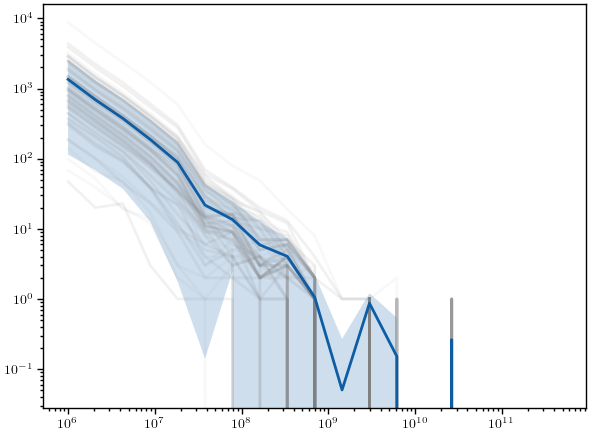

In [10]:
wdm_realizations = util.unpickle_all(ps_dir, 'wdm_realization_', '.pkl')
mdm_realizations = util.unpickle_all(ps_dir, 'mdm_realization_', '.pkl')
cdm_realizations = util.unpickle_all(ps_dir, 'cdm_realization_', '.pkl')

# get average number of subhalos
num_subhalos = []
for realization in cdm_realizations:
    num_subhalos.append(len(realization.halos))
avg = np.mean(num_subhalos)
print(f'Average number of subhalos: {round(avg)}')
print(f'Square root: {round(np.sqrt(avg))}')

cdm_list = []
for realization in cdm_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 12, 20))
    cdm_list.append(N)
    plt.loglog(m[:-1], N, alpha=0.05, color='grey')

print(m[:-1])
print(np.logspace(6, 12, 19))

m_mean = np.mean(cdm_list, axis=0)
print(m_mean.shape)

m_stdev = np.std(cdm_list, axis=0)
print(m_stdev.shape)

plt.loglog(m[:-1], m_mean)
plt.fill_between(m[:-1], m_mean - m_stdev, m_mean + m_stdev, alpha=0.2)
plt.show()

In [11]:
def get_bins_mean_std(realizations, num_bins):
    count_list = []

    for realization in realizations:
        cdm_halo_masses = [halo.mass for halo in realization.halos]
        count, bins = np.histogram(cdm_halo_masses, bins=np.logspace(6, 12, num_bins))
        count_list.append(count)

    return bins[:-1], np.mean(count_list, axis=0), np.std(count_list, axis=0)

bins_wdm, mean_wdm, std_wdm = get_bins_mean_std(wdm_realizations, 20)
bins_mdm, mean_mdm, std_mdm = get_bins_mean_std(mdm_realizations, 20)
bins_cdm, mean_cdm, std_cdm = get_bins_mean_std(cdm_realizations, 20)

Get power spectra of convergence maps

In [17]:
kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))
kappa_ps_wdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_wdm_*.npy'))]
kappa_ps_mdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_mdm_*.npy'))]
kappa_ps_cdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_cdm_*.npy'))]

stack_kappa_ps_wdm = np.vstack(kappa_ps_wdm)
stack_kappa_ps_mdm = np.vstack(kappa_ps_mdm)
stack_kappa_ps_cdm = np.vstack(kappa_ps_cdm)

mean_kappa_ps_wdm = np.mean(stack_kappa_ps_wdm, axis=0)
mean_kappa_ps_mdm = np.mean(stack_kappa_ps_mdm, axis=0)
mean_kappa_ps_cdm = np.mean(stack_kappa_ps_cdm, axis=0)

std_kappa_ps_wdm = np.std(stack_kappa_ps_wdm, axis=0, ddof=1)
std_kappa_ps_mdm = np.std(stack_kappa_ps_mdm, axis=0, ddof=1)
std_kappa_ps_cdm = np.std(stack_kappa_ps_cdm, axis=0, ddof=1)

assert mean_kappa_ps_wdm.shape == kappa_r.shape == std_kappa_ps_wdm.shape

Plot

ValueError: operands could not be broadcast together with shapes (19,) (30,) 

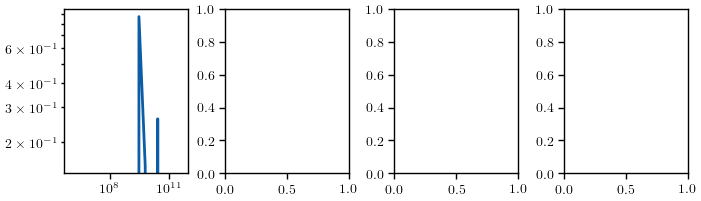

In [19]:
f, ax = plt.subplots(1, 4, figsize=(7, 2), constrained_layout=True)

ax[0].loglog(bins_wdm, mean_wdm, alpha=1., color='#0C5DA5', label='')
ax[0].fill_between(bins_wdm, mean_wdm - std_wdm, mean_wdm + std_wdm, alpha=0.1, color='#0C5DA5')
ax[0].loglog(bins_mdm, mean_mdm, alpha=1., color='#00B945', label='')
ax[0].fill_between(bins_mdm, mean_mdm - std_mdm, mean_mdm + std_mdm, alpha=0.1, color='#00B945')
ax[0].loglog(bins_cdm, mean_cdm, alpha=1., color='#FF9500', label='')
ax[0].fill_between(bins_cdm, mean_cdm - std_cdm, mean_cdm + std_cdm, alpha=0.1, color='#FF9500')
ax[0].set_xlabel('Halo mass [' + r'$M_{\odot}$]')
ax[0].set_ylabel('Count')
ax[0].legend()

ax[1].loglog(kappa_r, mean_kappa_ps_wdm, alpha=1., color='#0C5DA5', label='')
ax[1].fill_between(kappa_r, mean_kappa_ps_wdm - std_kappa_ps_wdm, mean_kappa_ps_wdm + std_kappa_ps_wdm, alpha=0.1, color='#0C5DA5')
ax[1].loglog(kappa_r, mean_kappa_ps_mdm, alpha=1., color='#00B945', label='')
ax[1].fill_between(kappa_r, mean_kappa_ps_mdm - std_kappa_ps_mdm, mean_kappa_ps_mdm + std_kappa_ps_mdm, alpha=0.1, color='#00B945')
ax[1].loglog(kappa_r, mean_kappa_ps_cdm, alpha=1., color='#FF9500', label='')
ax[1].fill_between(kappa_r, mean_kappa_ps_cdm - std_kappa_ps_cdm, mean_kappa_ps_cdm + std_kappa_ps_cdm, alpha=0.1, color='#FF9500')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend()

ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[2].plot(r, res_wdm, color='#0C5DA5')
ax[2].fill_between(r, res_wdm - std_wdm, res_wdm + std_wdm, alpha=0.1, color='#0C5DA5')
ax[2].plot(r, res_mdm, color='#00B945')
ax[2].fill_between(r, res_mdm - std_mdm, res_mdm + std_mdm, alpha=0.1, color='#00B945')
ax[2].set_xscale('log')
ax[2].set_xlabel('Radius [pixels]')
ax[2].set_ylabel(r'$P - P_{\textrm{CDM}}$')

ax[3].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[3].plot(r, dif_pos_1, color='#FF2C00', label='Middle: SCA01')
ax[3].plot(r, dif_pos_2, color='#845B97', label='Far left: SCA09')
ax[3].plot(r, dif_pos_3, color='#474747', label='Far right: SCA17')
ax[3].fill_between(r, dif_pos_1 - std_pos_1, dif_pos_1 + std_pos_1, alpha=0.1, color='#FF2C00')
ax[3].fill_between(r, dif_pos_2 - std_pos_2, dif_pos_2 + std_pos_2, alpha=0.1, color='#845B97')
ax[3].fill_between(r, dif_pos_3 - std_pos_3, dif_pos_3 + std_pos_3, alpha=0.1, color='#474747')
ax[3].set_xscale('log')
ax[3].set_xlabel('Radius [pixels]')
ax[3].set_ylabel(r'$P - P_{\textrm{SCA02, (2048, 2048)}}$')
ax[3].legend()
ax[3].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[3].sharey(ax[2])

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
plt.show()